In [2]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import random

# keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#from astropy.visualization import make_lupton_rgb

In [3]:
config1 = np.load('D:/SL CNN/CONFIGURATION_1_images1.npy')
config2 = np.load('D:/SL CNN/CONFIGURATION_2_images1.npy')

In [4]:
print(np.shape(config1))
print(np.shape(config2))

(1249, 3, 100, 100)
(1249, 3, 100, 100)


In [8]:
data = np.concatenate((config1, config2), axis=0)
print(np.shape(data))

(2498, 3, 100, 100)


In [9]:
label1 = np.ones(len(config1[0:]))
label2 = np.zeros(len(config2[0:]))
label = np.concatenate((label1, label2))
print(np.shape(label))

(2498,)


In [27]:
#get random indices
x = np.empty(1)
i = 1

while i < 16:
    example_num = int(random.randrange(0, len(data[0:])))
    if example_num != x[i-1]:
        x = np.append(x, [example_num])
        i += 1

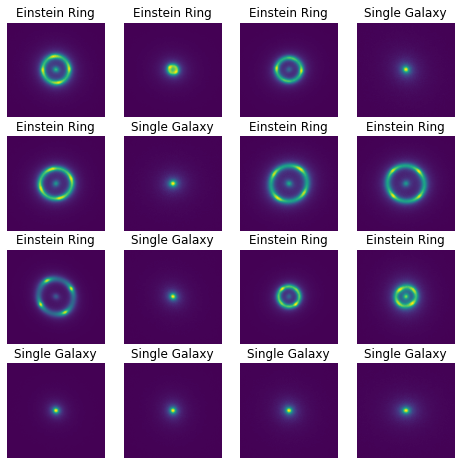

In [31]:
#plot the examples
fig1=plt.figure(figsize=(8,8))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    
    example_indices = int(x[i])
    
    example_image = np.squeeze(data[example_indices:(example_indices + 1), 0:1]) #change band by switching 0:1 to 1:2 or 2:3
    
    plt.imshow(example_image, aspect='auto', cmap='viridis')
    if label[example_indices] == 1:
        plt.title('Einstein Ring')
    else:
        plt.title('Single Galaxy')

In [9]:
y = label.astype('float32')
X = data.astype('float32')

In [10]:
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=42, shuffle=True)

In [12]:
imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valid = X_valid.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)

print(np.shape(X_train))

(1748, 100, 100, 3)


In [13]:
imsize = np.shape(X_train)[2]

# Model used was created by A. Ciprijanovic, as described in Section 3 of https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract

# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

model = Model(inputs=x_in, outputs=y_out)

In [14]:
optimizer = 'adam'
metrics = ['accuracy']
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 8)       608       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        1168  

In [15]:
nb_epoch = 20
batch_size = 128
shuffle = True

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_valid, y_valid),                
                    shuffle=shuffle,
                    verbose=True)

Epoch 1/20
14/14 [==============================] - 6s 234ms/step - loss: 0.7019 - accuracy: 0.8713 - val_loss: 0.7042 - val_accuracy: 0.4720
Epoch 2/20
14/14 [==============================] - 3s 222ms/step - loss: 0.6908 - accuracy: 0.9823 - val_loss: 0.7002 - val_accuracy: 0.4720
Epoch 3/20
14/14 [==============================] - 3s 221ms/step - loss: 0.6847 - accuracy: 0.9908 - val_loss: 0.6927 - val_accuracy: 0.6640
Epoch 4/20
14/14 [==============================] - 3s 226ms/step - loss: 0.6802 - accuracy: 0.9931 - val_loss: 0.6799 - val_accuracy: 0.9480
Epoch 5/20
14/14 [==============================] - 3s 225ms/step - loss: 0.6763 - accuracy: 0.9937 - val_loss: 0.6753 - val_accuracy: 0.9680
Epoch 6/20
14/14 [==============================] - 3s 228ms/step - loss: 0.6722 - accuracy: 0.9949 - val_loss: 0.6706 - val_accuracy: 0.9840
Epoch 7/20
14/14 [==============================] - 4s 259ms/step - loss: 0.6682 - accuracy: 0.9937 - val_loss: 0.6664 - val_accuracy: 0.9920
Epoch 

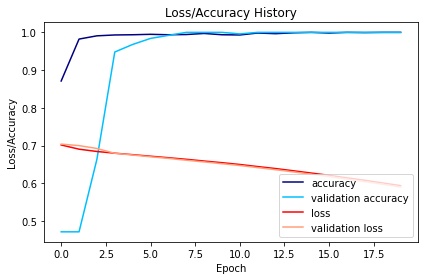

In [21]:
# plot

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')

In [17]:
score = model.evaluate(X_test, y_test, verbose=True)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

16/16 [==============================] - 0s 14ms/step - loss: 0.5904 - accuracy: 1.0000
accuracy: 100.00%


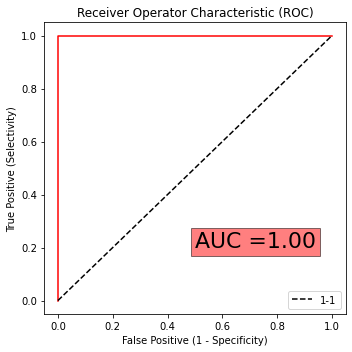

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, prob, pos_label=1)
auc = roc_auc_score(y_test, prob)


figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
plt.plot(fpr, tpr, 'r-')
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.text(0.5, 0.2, "AUC ="+"{0:.2f}".format(auc), fontsize = 22, 
         bbox = dict(facecolor = 'red', alpha = 0.5))
plt.tight_layout()

In [20]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, pred)
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
